![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [48]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [49]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [50]:
# Celda 1
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [51]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [52]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [53]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [54]:
# Aplicación de la función tree_grow
tree= tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)

In [55]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [56]:
# Ejecución de función tree_predict
prediccion= tree_predict(X_test, tree)

In [57]:
# Cálculo del accuracy

accuracy_1=0
for i in range(0,len(y_test)):
    if (y_test.iloc[i]==prediccion[i]):
        accuracy_1+=1/len(y_test)
        
print('El accuracy en la muestra de test es:')
print(accuracy_1)

El accuracy en la muestra de test es:
0.8879907621246753


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [58]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [59]:
# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,2016,40999,0,0,0,0,0,1,0
171999,2014,52527,0,0,0,0,0,1,0
304172,2009,123202,0,1,0,0,0,0,0
74828,2015,38807,0,0,0,0,0,1,0
192974,2005,51260,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
134843,2014,22221,0,0,0,0,1,0,0
325075,2013,86593,0,0,0,0,0,1,0
61213,2014,28044,0,0,0,0,0,1,0
181222,2016,49368,0,0,0,0,0,0,1


In [60]:
# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeClassifier

# Definición del modelo usando DecisionTreeClassifier de sklearn
treecl = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    XTrain = X_train.iloc[sample, :]
    yTrain = y_train.iloc[sample]
    treecl.fit(XTrain, yTrain)
    y_pred.iloc[:,i] = treecl.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,0,0,0,0,0,0,0,0,0,0
326011,0,0,0,0,0,0,0,0,0,0
242354,1,1,1,1,1,1,1,1,1,1
266376,1,1,1,1,1,1,1,1,1,1
396954,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
144298,1,0,1,1,0,0,1,1,1,1
364521,1,1,1,1,1,1,1,1,1,1
120072,1,1,1,1,1,1,1,1,1,1
99878,0,0,0,0,0,0,0,0,0,0


In [61]:
# Obteniendo el resultado de los 10 árboles según el valor más común

from statistics import mode

prediccion = []

for i in range(len(y_pred[0])):
    prediccion.append(mode(y_pred.iloc[i,:]))


In [62]:
# Cálculo del accuracy

accuracy_2=0
for i in range(0,len(y_test)):
    if (y_test.iloc[i]==prediccion[i]):
        accuracy_2+=1/len(y_test)
        
print('El accuracy en la muestra de test es:')
print(accuracy_2)

El accuracy en la muestra de test es:
0.8510392609699432


### Comentarios

- Observamos que el Bagging manual con 10 árboles de clasificación, nos da un accuracy en la muestra de test de 0.8510, muy similar al que obtuvimos en el punto 1 con un único árbol de clasificación, obteniendo un accuracy en la muestra de test de 0.8582

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [63]:
# Celda 3

# Uso de BaggingClassifier de la libreria (sklearn) donde se usa el modelo DecisionTreeClassifier como estimador

import math

from sklearn.ensemble import BaggingClassifier
bagcl = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_features= (math.log2(len(X_train.columns))) / (len(X_train.columns)),
                          bootstrap=True, oob_score=True, random_state=1)

In [64]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagcl.fit(X_train, y_train)
y_pred = bagcl.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [65]:
# Cálculo del accuracy

accuracy_3=0
for i in range(0,len(y_test)):
    if (y_test.iloc[i]==y_pred[i]):
        accuracy_3+=1/len(y_test)
        
print('El accuracy en la muestra de test es:')
print(accuracy_3)

El accuracy en la muestra de test es:
0.8666281755195958


### Comentarios

- En este caso, usando el Bagging con librería, en donde hemos podido utilizar el parámetro max_features, obtenemos un mejor desempeño sobre la muestra de test (accuracy = 0.8666)

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [66]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [67]:
prediccion=clf.predict(X_test)

In [68]:
# Cálculo del mse

accuracy_4=0
for i in range(0,len(y_test)):
    if (y_test.iloc[i]==prediccion[i]):
        accuracy_4+=1/len(y_test)
        
print('El accuracy en la muestra de test es:')
print(accuracy_4)

El accuracy en la muestra de test es:
0.8438221709006596


### Comentarios

- Al utilizar Random Forest de librería sin calibrar ningún parámetro obtenemos un menor desempeño que en los ejercicios anteriores (accuracy de 0.8438 sobre la muestra de test)

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [69]:
# Celda 5

# Calibración de max_depth

# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range =  range(1, len(X_train.columns)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

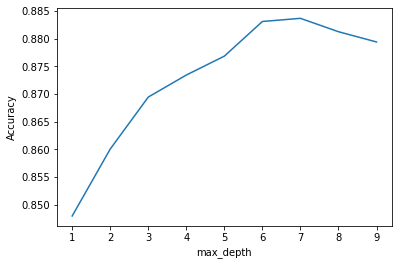

In [70]:
# Gráfica del desempeño del modelo vs max_depth

import matplotlib.pyplot as plt

plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [71]:
accuracy_scores.index(max(accuracy_scores))+1

7

In [72]:
#Calibración de n_estimators

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range =  range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(max_depth=6, n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

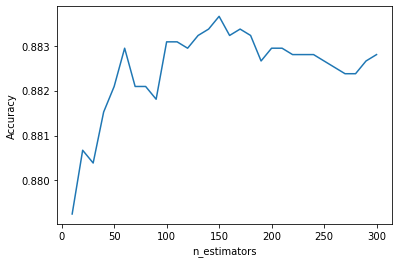

In [73]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators

import matplotlib.pyplot as plt

plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [74]:
accuracy_scores.index(max(accuracy_scores))+1

15

In [75]:
# Calibración de max_features

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X_train.columns)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(max_depth=7, n_estimators=80, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

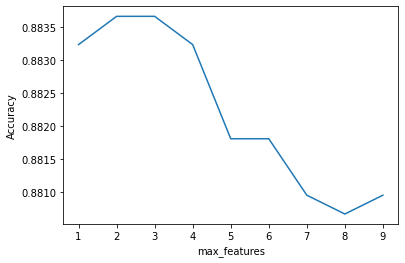

In [76]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [77]:
accuracy_scores.index(max(accuracy_scores))+1

3

In [78]:
# Definición del modelo con los parámetros max_features=8 y n_estimators=7 
clf = RandomForestClassifier(max_depth=7, n_estimators=80, max_features=3, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=3, n_estimators=80, n_jobs=-1,
                       random_state=1)

In [79]:
prediccion=clf.predict(X_test)

In [80]:
# Cálculo del accuracy

accuracy_5=0
for i in range(0,len(y_test)):
    if (y_test.iloc[i]==prediccion[i]):
        accuracy_5+=1/len(y_test)
        
print('El accuracy en la muestra de test es:')
print(accuracy_5)

El accuracy en la muestra de test es:
0.8868360277135899


### Comentarios

- Observamos que al calibrar los 3 parámetros (max_depth, max_features y n_estimators) el desempeño del modelo mejora considerablemente, obteniendo un accuracy sobre la muestra de test de 0.8868

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [81]:
# Celda 6

# Importación y definición de modelo XGBClassifier

from xgboost import XGBClassifier
from sklearn import metrics
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [82]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_6= metrics.accuracy_score(y_pred, y_test.values)
print('El accuracy en la muestra de test es:')
print(accuracy_6)

[19:58:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
El accuracy en la muestra de test es:
0.8856812933025404


### Comentarios

- Se puede observar que el modelo XGBoost presenta un buen desempeño, inclusive sin calibrar ningún parámetro, obteniendo un accuracy sobre la muesta de test de 0.8856 (casi como el Random Forest calibrado)

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [270]:
# Celda 7

# Calibración de learning_rate

# Creación de lista de valores para iterar sobre diferentes valores de learning_rate
learning_range = range(0, 11, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de learning_rate
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de learning_rate
for l in learning_range:
    clf = XGBClassifier(learning_range= l/10)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

[21:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenl

[21:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenl

[21:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenl

[21:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenl

[21:36:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:36:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learning_range" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenl

Text(0, 0.5, 'Accuracy')

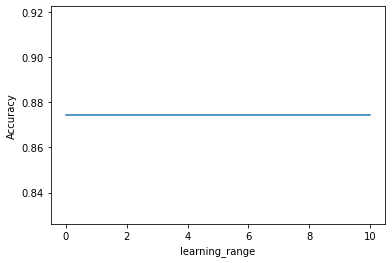

In [271]:
# Gráfica del desempeño del modelo vs learning_rate
plt.plot(learning_range, accuracy_scores)
plt.xlabel('learning_range')
plt.ylabel('Accuracy')

In [272]:
accuracy_scores.index(max(accuracy_scores))

0

In [273]:
# Calibración de gamma

# Creación de lista de valores para iterar sobre diferentes valores de gamma
gamma_range = range(0, 100, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de gamma
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de gamma
for g in gamma_range:
    clf = XGBClassifier(gamma= g)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())


[21:36:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:36:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Text(0, 0.5, 'Accuracy')

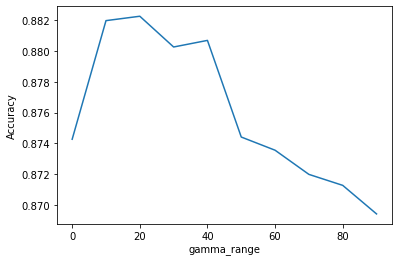

In [274]:
# Gráfica del desempeño del modelo vs gamma
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma_range')
plt.ylabel('Accuracy')

In [275]:
accuracy_scores.index(max(accuracy_scores))

2

In [276]:
# Calibración de colsample_bytree

# Creación de lista de valores para iterar sobre diferentes valores de colsample_bytree
col_range = range(1, len(X_train.columns)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de colsample_bytree
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de colsample_bytree
for c in col_range:
    clf = XGBClassifier(gamma= 20, colsample_bytree=c/len(X_train.columns))
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())


[21:37:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:37:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Text(0, 0.5, 'Accuracy')

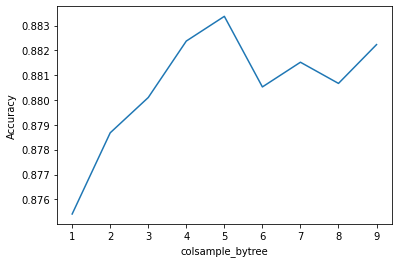

In [277]:
# Gráfica del desempeño del modelo vs colsample_bytree
plt.plot(col_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')

In [282]:
accuracy_scores.index(max(accuracy_scores)) + 1

5

In [283]:
clf = XGBClassifier(gamma= 20, colsample_bytree=5/len(X_train.columns))

In [284]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_7= metrics.accuracy_score(y_pred, y_test.values)
print('El accuracy en la muestra de test es:')
print(accuracy_7)

[21:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
El accuracy en la muestra de test es:
0.8903002309468823


### Comentarios

- Se puede ver que al calibrar los 3 parámetros (learning_rate, gamma y colsample_bytree) el desempeño del modelo mejora un poco, obteniendo un accuracy sobre la muestra de test de 0.8903.

- Se puede observar también que el parámetro learning_rate no aporta a la calibración, ya que en cualquiera de sus valores (en el rango de 0 a 1) se obtiene el mismo accuracy.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

## Celda 8

### Comparación de Modelos

El Random Forest calibrado arroja un accuracy de 0.8868
El XGBoost calibrado arroja un accuracy de 0.8903

Por lo tanto, el XGBoost desempeña mejor


